Main index type: <class 'faiss.swigfaiss.IndexIDMap'>
Base index type: <class 'faiss.swigfaiss.IndexFlatL2'>
Base index attributes: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__swig_destroy__', '__weakref__', 'add', 'add_c', 'add_with_ids', 'add_with_ids_c', 'assign', 'assign_c', 'cached_l2norms', 'check_compatible_for_merge', 'clear_l2norms', 'code_size', 'codes', 'compute_distance_subset', 'compute_residual', 'compute_residual_n', 'd', 'get_CodePacker', 'get_FlatCodesDistanceComputer', 'get_distance_computer', 'get_xb', 'is_trained', 'merge_from', 'metric_arg', 'metric_type', 'ntotal', 'permute_entries', 'permute_entries_c', 'range_search', 'range_search_c', 'reconstruc

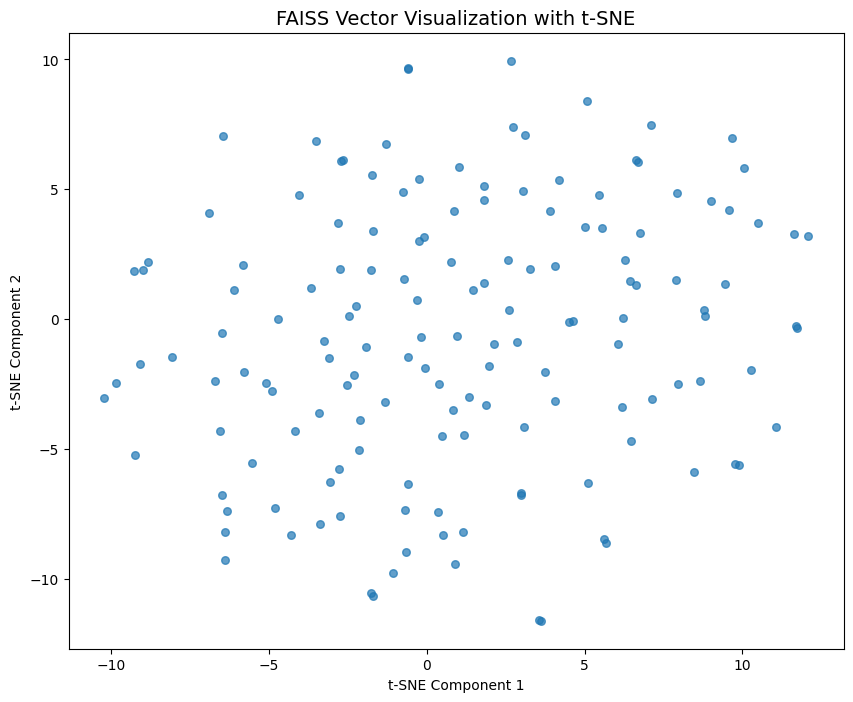

In [1]:
import faiss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load the index
index = faiss.read_index("ideas1.faiss")

print("Main index type:", type(index))

# For IndexIDMap, we need to access the underlying index
if isinstance(index, faiss.IndexIDMap):
    base_index = faiss.downcast_index(index.index)
    print("Base index type:", type(base_index))
    print("Base index attributes:", dir(base_index))
    
    # Try different methods to access vectors
    if hasattr(base_index, 'xb'):
        print("Index has xb attribute")
        vectors = np.array(base_index.xb).reshape(base_index.ntotal, base_index.d)
    elif hasattr(base_index, 'reconstruct_n'):
        print("Index has reconstruct_n method")
        vectors = np.empty((base_index.ntotal, base_index.d), dtype=np.float32)
        base_index.reconstruct_n(0, base_index.ntotal, vectors)
    elif hasattr(base_index, 'ivf'):
        print("Index has ivf attribute")
        invlists = base_index.invlists
        vectors = []
        for i in range(base_index.nlist):
            list_size = invlists.list_size(i)
            if list_size > 0:
                list_vectors = faiss.rev_swig_ptr(invlists.get_codes(i), list_size * base_index.code_size)
                vectors.extend(list_vectors)
        vectors = np.array(vectors, dtype=np.float32)
    else:
        print("Could not find a way to access vectors. Available attributes:", dir(base_index))
        raise ValueError("Cannot access vectors from this index type")
else:
    print("Not an IndexIDMap")
    raise ValueError("Unexpected index type")

print("Vector shape:", vectors.shape)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], s=30, alpha=0.7)
plt.title("FAISS Vector Visualization with t-SNE", fontsize=14)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

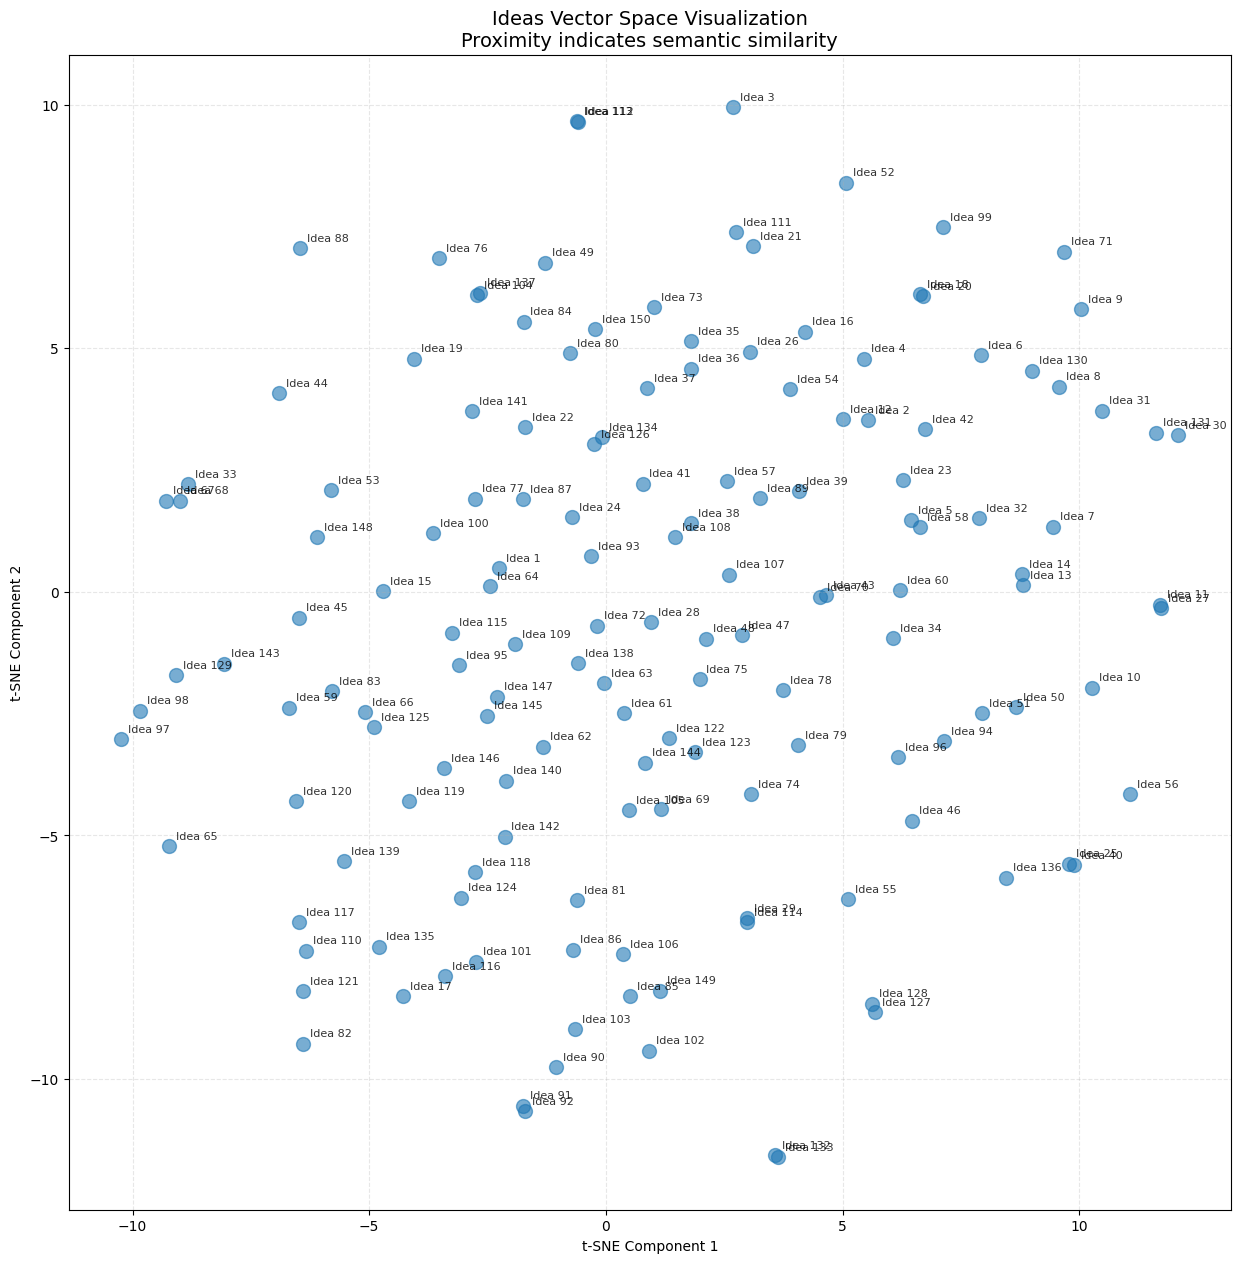


Most semantically similar pairs of ideas:
Ideas 91 and 92
Ideas 92 and 91
Ideas 112 and 113
Ideas 113 and 112
Ideas 104 and 137


In [2]:
import faiss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load the index
index = faiss.read_index("ideas1.faiss")
base_index = faiss.downcast_index(index.index)

# Get vectors
vectors = np.empty((base_index.ntotal, base_index.d), dtype=np.float32)
base_index.reconstruct_n(0, base_index.ntotal, vectors)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the plot
plt.figure(figsize=(15, 15))

# Plot points
scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], s=100, alpha=0.6)

# Add idea numbers as labels
for idx in range(len(reduced_vectors)):
    plt.annotate(f"Idea {idx+1}", 
                (reduced_vectors[idx, 0], reduced_vectors[idx, 1]),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=8,
                alpha=0.8)

plt.title("Ideas Vector Space Visualization\nProximity indicates semantic similarity", fontsize=14)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

# Print closest pairs of ideas
from scipy.spatial.distance import pdist, squareform

# Calculate pairwise distances
distances = squareform(pdist(vectors))
np.fill_diagonal(distances, np.inf)  # Ignore self-similarity

# Get top 5 closest pairs
n_pairs = 5
closest_pairs = []
for _ in range(n_pairs):
    min_idx = np.unravel_index(distances.argmin(), distances.shape)
    closest_pairs.append((min_idx[0]+1, min_idx[1]+1, distances[min_idx]))
    distances[min_idx] = np.inf

print("\nMost semantically similar pairs of ideas:")
for idea1, idea2, distance in closest_pairs:
    print(f"Ideas {idea1} and {idea2}")

In [3]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

# Load your existing index and get vectors
index = faiss.read_index("ideas1.faiss")
base_index = faiss.downcast_index(index.index)
vectors = np.empty((base_index.ntotal, base_index.d), dtype=np.float32)
base_index.reconstruct_n(0, base_index.ntotal, vectors)

# Load the same model you used to create the embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # or whatever model you used

# Concepts to explore
concepts = [
    "beauty",
    "meditation",
    "philosophy",
    "expression",
    "power",
    "silence"
]

# Get embeddings for concepts
concept_embeddings = model.encode(concepts)

# Create a flat index for similarity search
concept_index = faiss.IndexFlatL2(vectors.shape[1])
concept_index.add(vectors)

# Find nearest ideas for each concept
k = 3  # number of nearest ideas to find
for concept, concept_vec in zip(concepts, concept_embeddings):
    print(f"\nTop ideas related to '{concept}':")
    D, I = concept_index.search(concept_vec.reshape(1, -1), k)
    for idx, dist in zip(I[0], D[0]):
        print(f"Idea {idx+1} (distance: {dist:.2f})")


Top ideas related to 'beauty':
Idea 1 (distance: 0.91)
Idea 64 (distance: 1.01)
Idea 147 (distance: 1.31)

Top ideas related to 'meditation':
Idea 58 (distance: 0.63)
Idea 5 (distance: 0.66)
Idea 23 (distance: 0.91)

Top ideas related to 'philosophy':
Idea 10 (distance: 1.12)
Idea 14 (distance: 1.25)
Idea 9 (distance: 1.27)

Top ideas related to 'expression':
Idea 113 (distance: 1.29)
Idea 112 (distance: 1.38)
Idea 2 (distance: 1.43)

Top ideas related to 'power':
Idea 20 (distance: 1.27)
Idea 4 (distance: 1.34)
Idea 77 (distance: 1.38)

Top ideas related to 'silence':
Idea 12 (distance: 0.91)
Idea 4 (distance: 1.37)
Idea 22 (distance: 1.38)


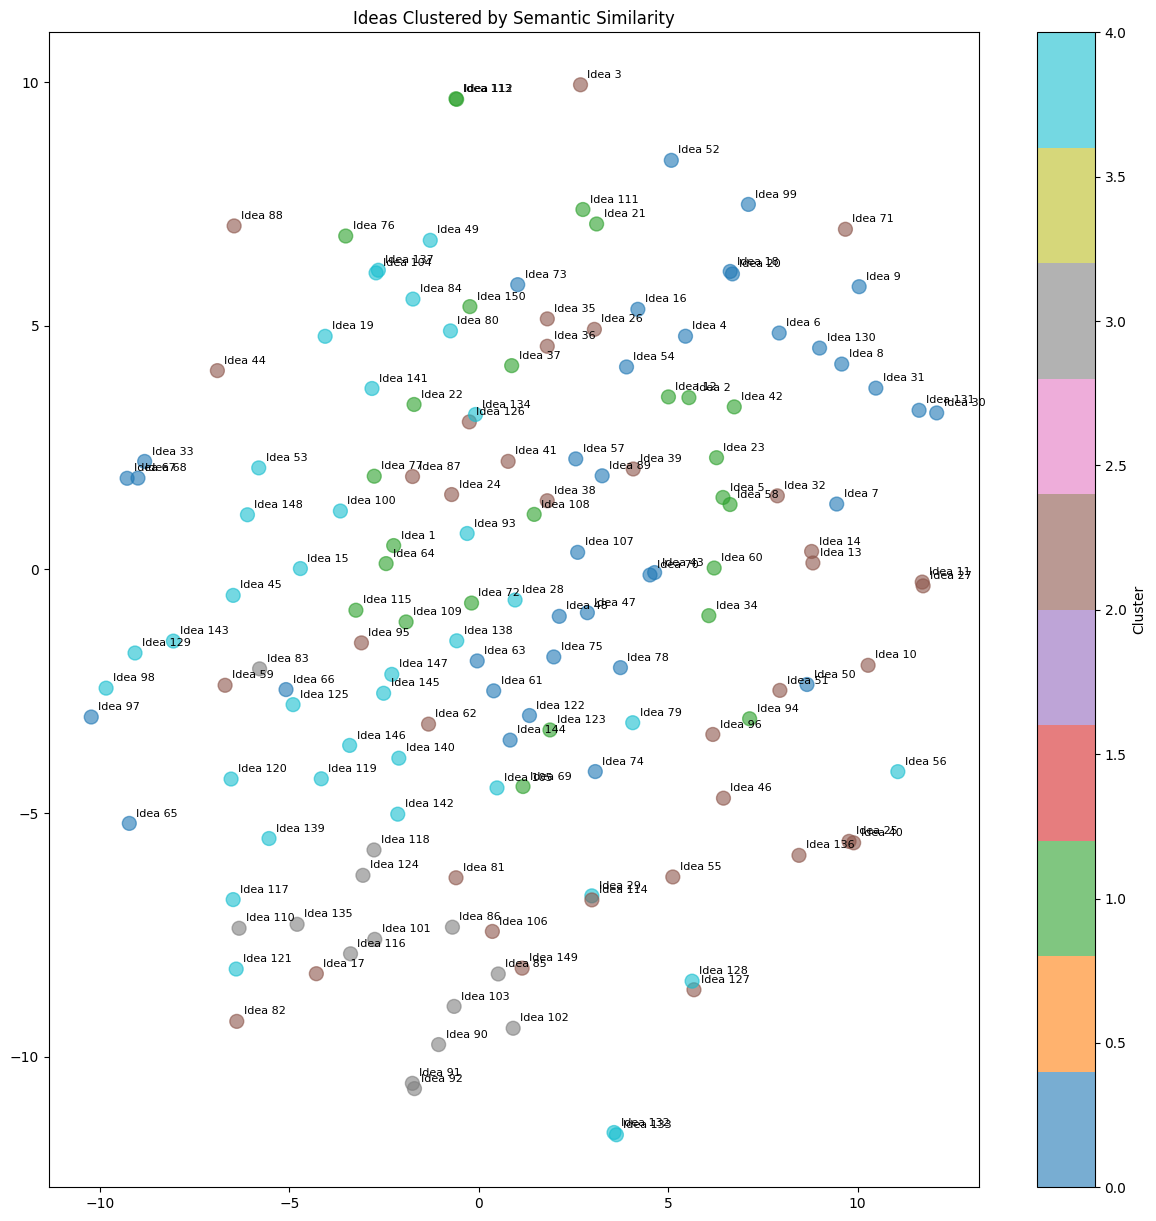


Cluster 0:
Ideas: [4, 6, 7, 8, 9, 16, 18, 20, 30, 31, 33, 43, 47, 48, 50, 52, 54, 57, 61, 63, 65, 66, 67, 68, 70, 73, 74, 75, 78, 89, 97, 99, 107, 122, 130, 131, 144]

Cluster 1:
Ideas: [1, 2, 5, 12, 21, 22, 23, 34, 37, 42, 58, 60, 64, 69, 72, 76, 77, 94, 108, 109, 111, 112, 113, 115, 123, 150]

Cluster 2:
Ideas: [3, 10, 11, 13, 14, 17, 24, 25, 26, 27, 32, 35, 36, 38, 39, 40, 41, 44, 46, 51, 55, 59, 62, 71, 81, 82, 87, 88, 95, 96, 106, 114, 126, 127, 136, 149]

Cluster 3:
Ideas: [83, 85, 86, 90, 91, 92, 101, 102, 103, 110, 116, 118, 124, 135]

Cluster 4:
Ideas: [15, 19, 28, 29, 45, 49, 53, 56, 79, 80, 84, 93, 98, 100, 104, 105, 117, 119, 120, 121, 125, 128, 129, 132, 133, 134, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148]


In [4]:
from sklearn.cluster import KMeans
import numpy as np

# Perform clustering
n_clusters = 5  # adjust based on your needs
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(vectors)

# Create visualization with clusters
plt.figure(figsize=(15, 15))

# Get t-SNE coordinates if you haven't already
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Plot with colors by cluster
scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], 
                     c=clusters, cmap='tab10', s=100, alpha=0.6)

# Add idea numbers
for idx in range(len(reduced_vectors)):
    plt.annotate(f"Idea {idx+1}", 
                (reduced_vectors[idx, 0], reduced_vectors[idx, 1]),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=8)

plt.title("Ideas Clustered by Semantic Similarity")
plt.colorbar(scatter, label="Cluster")
plt.show()

# Print clusters
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    ideas_in_cluster = np.where(clusters == cluster)[0]
    print(f"Ideas: {[i+1 for i in ideas_in_cluster]}")

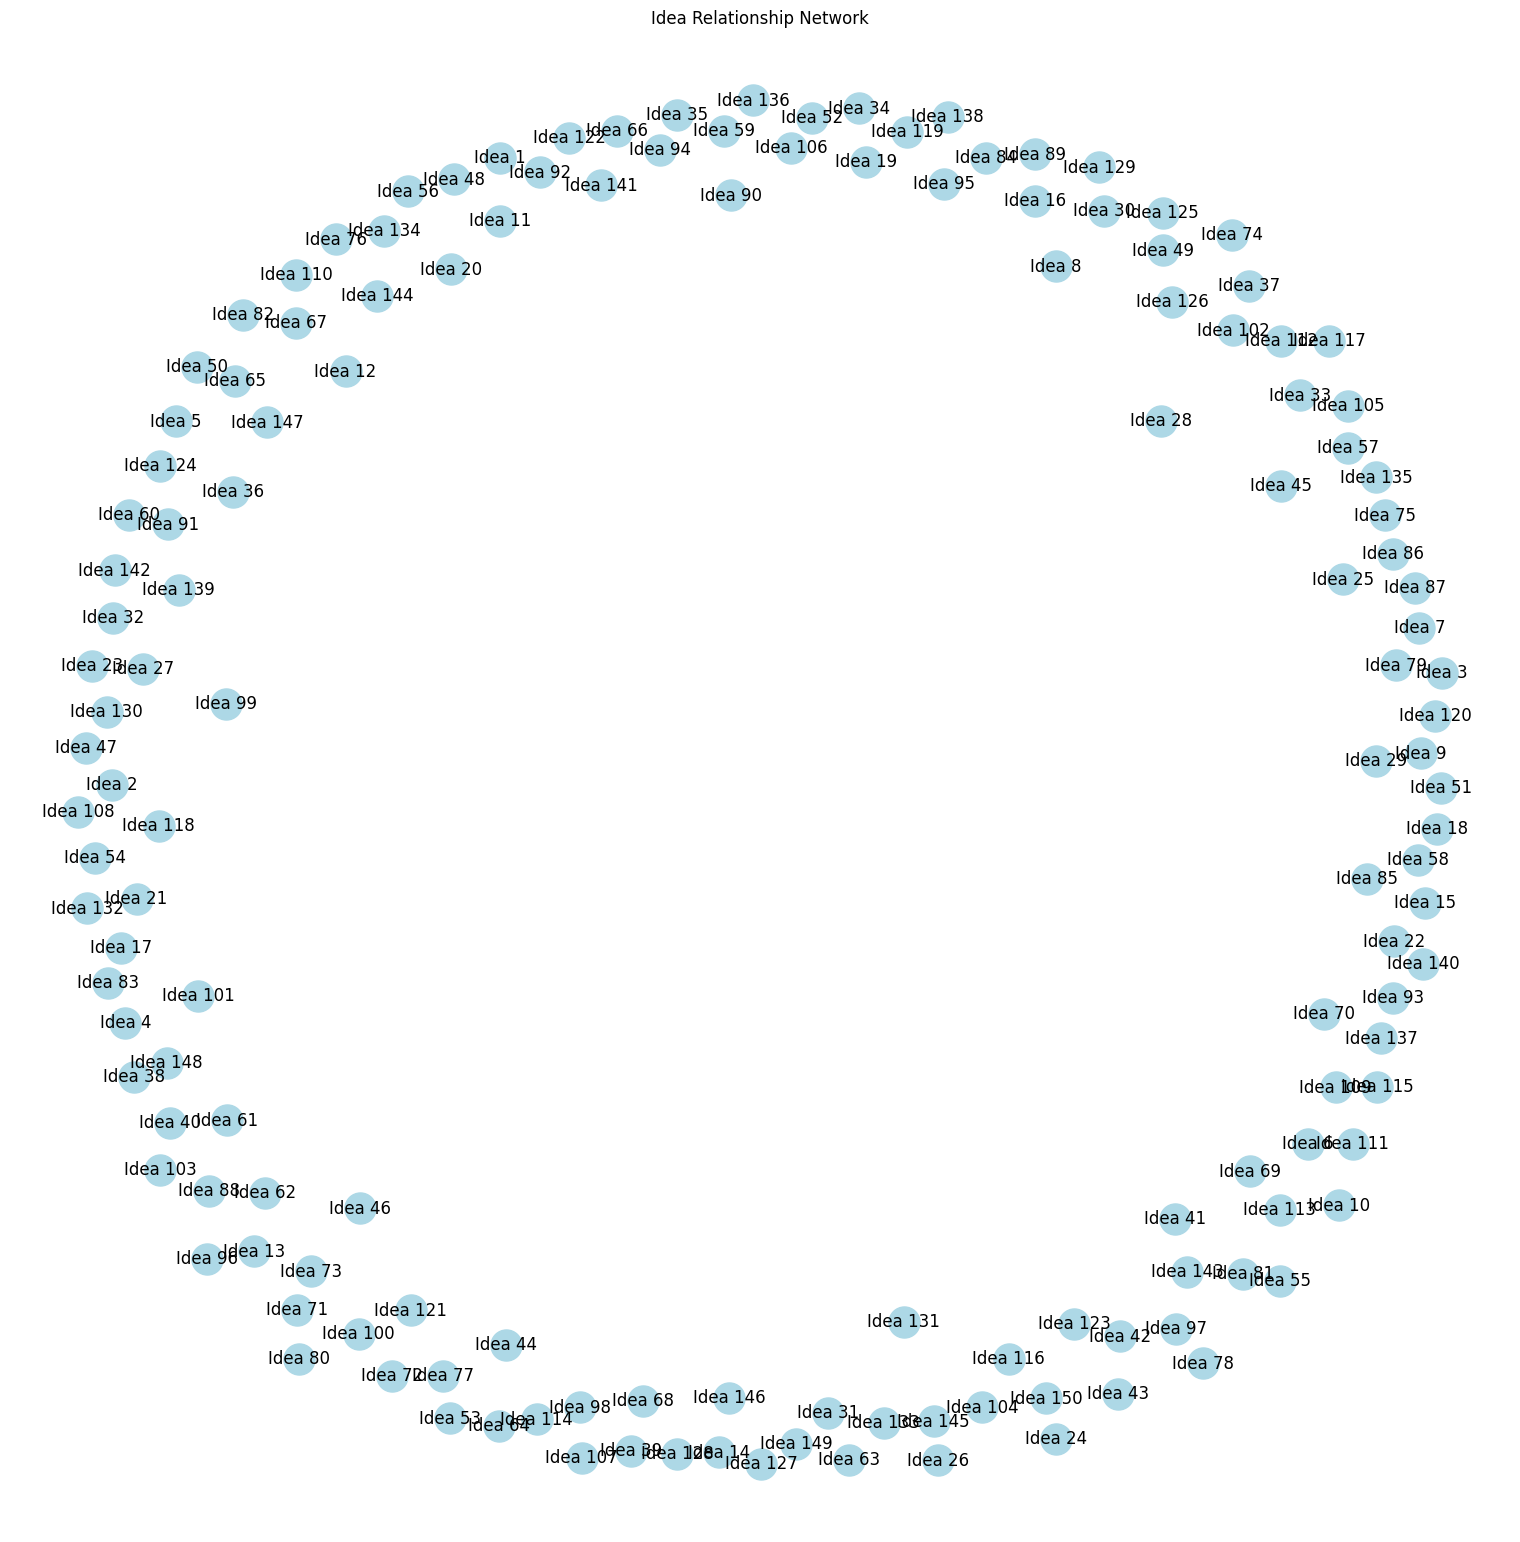


Most connected ideas:
Idea 1: 0.000
Idea 2: 0.000
Idea 3: 0.000
Idea 4: 0.000
Idea 5: 0.000


In [5]:
import networkx as nx
from scipy.spatial.distance import cosine

# Create a graph of idea relationships
G = nx.Graph()

# Add nodes
for i in range(len(vectors)):
    G.add_node(i, idea_num=i+1)

# Add edges between similar ideas (using cosine similarity threshold)
threshold = 0.8  # adjust as needed
for i in range(len(vectors)):
    for j in range(i+1, len(vectors)):
        similarity = 1 - cosine(vectors[i], vectors[j])
        if similarity > threshold:
            G.add_edge(i, j, weight=similarity)

# Draw the network
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G)
nx.draw(G, pos, 
        node_color='lightblue',
        node_size=500,
        with_labels=True,
        labels={n: f"Idea {G.nodes[n]['idea_num']}" for n in G.nodes()})
plt.title("Idea Relationship Network")
plt.show()

# Print most central ideas
centrality = nx.degree_centrality(G)
print("\nMost connected ideas:")
for node, score in sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"Idea {G.nodes[node]['idea_num']}: {score:.3f}")